# AdaBoost Training for Viola-Jones Face Detector

Train AdaBoost classifier on face patches using Haar features.

**V1 Configuration**:
- Features: 10,000 Haar features
- Rounds: T=50
- Dataset: 799 face + 3,995 non-face patches

**AI Usage**: Notebook structure assisted by Claude Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path
from tqdm import tqdm

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from features.integral_image import compute_ii_fast
from features.haar_features import generate_haar_features, compute_feature_responses
from classifiers.adaboost import train_adaboost, evaluate_classifier

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Dataset

In [2]:
print("Loading dataset...")

# Load training data
with open('../data/processed/train_faces.pkl', 'rb') as f:
    train_faces = pickle.load(f)

with open('../data/processed/train_nonfaces.pkl', 'rb') as f:
    train_nonfaces = pickle.load(f)

# Load testing data
with open('../data/processed/test_faces.pkl', 'rb') as f:
    test_faces = pickle.load(f)

with open('../data/processed/test_nonfaces.pkl', 'rb') as f:
    test_nonfaces = pickle.load(f)

print(f"Training: {len(train_faces)} faces, {len(train_nonfaces)} non-faces")
print(f"Testing: {len(test_faces)} faces, {len(test_nonfaces)} non-faces")

Loading dataset...
Training: 799 faces, 3995 non-faces
Testing: 2260 faces, 11300 non-faces


## 2. Prepare Training Data

Combine faces and non-faces into single arrays with labels

In [3]:
# Combine training data
X_train = np.concatenate([train_faces, train_nonfaces], axis=0)
y_train = np.concatenate([
    np.ones(len(train_faces), dtype=int),   # faces = 1
    np.zeros(len(train_nonfaces), dtype=int)  # non-faces = 0
])

# Combine testing data
X_test = np.concatenate([test_faces, test_nonfaces], axis=0)
y_test = np.concatenate([
    np.ones(len(test_faces), dtype=int),
    np.zeros(len(test_nonfaces), dtype=int)
])

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"  Positive (faces): {np.sum(y_train == 1)}")
print(f"  Negative (non-faces): {np.sum(y_train == 0)}")
print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  Positive (faces): {np.sum(y_test == 1)}")
print(f"  Negative (non-faces): {np.sum(y_test == 0)}")


Training set: 4794 samples
  Positive (faces): 799
  Negative (non-faces): 3995

Test set: 13560 samples
  Positive (faces): 2260
  Negative (non-faces): 11300


## 3. Generate Haar Features

Generate 10,000 features for V1 (simplified version)

In [4]:
print("Generating Haar features...")
features = generate_haar_features(window_size=16, max_features=10000)
print(f"\nGenerated {len(features)} Haar features")

# Show first few features
print("\nFirst 5 features:")
for i, feat in enumerate(features[:5]):
    print(f"  {i+1}. {feat}")

Generating Haar features...
Generating Haar features for 16×16 window...
  Generating 2-rectangle horizontal features...
  Generating 2-rectangle vertical features...

Generated 10000 Haar features

First 5 features:
  1. HaarFeature(type=2h, pos=(0,0), size=1x2)
  2. HaarFeature(type=2h, pos=(0,0), size=1x4)
  3. HaarFeature(type=2h, pos=(0,0), size=1x6)
  4. HaarFeature(type=2h, pos=(0,0), size=1x8)
  5. HaarFeature(type=2h, pos=(0,0), size=1x10)


## 4. Compute Feature Response Matrix

**This is computationally expensive!**
- Training: 4,794 patches x 10,000 features = 47.9M evaluations
- Testing: 13,560 patches x 10,000 features = 135.6M evaluations

Pre-computing and saving for reuse.

In [5]:
# Check if already computed
train_response_file = Path('../data/processed/train_responses_10k.npy')
test_response_file = Path('../data/processed/test_responses_10k.npy')

if train_response_file.exists():
    print("Loading pre-computed training responses...")
    train_responses = np.load(train_response_file)
else:
    print("Computing training feature responses...")
    print("This may take several minutes...")
    train_responses = compute_feature_responses(features, X_train)
    np.save(train_response_file, train_responses)
    print(f"Saved to {train_response_file}")

print(f"\nTraining response matrix: {train_responses.shape}")
print(f"  Memory: {train_responses.nbytes / 1e6:.1f} MB")

Loading pre-computed training responses...

Training response matrix: (4794, 10000)
  Memory: 191.8 MB


In [6]:
if test_response_file.exists():
    print("Loading pre-computed testing responses...")
    test_responses = np.load(test_response_file)
else:
    print("Computing testing feature responses...")
    print("This may take several minutes...")
    test_responses = compute_feature_responses(features, X_test)
    np.save(test_response_file, test_responses)
    print(f"Saved to {test_response_file}")

print(f"\nTesting response matrix: {test_responses.shape}")
print(f"  Memory: {test_responses.nbytes / 1e6:.1f} MB")

Loading pre-computed testing responses...

Testing response matrix: (13560, 10000)
  Memory: 542.4 MB


## 5. Train AdaBoost Classifier

Train with T=50 rounds (V1 simplified version)

In [7]:
# Train AdaBoost
T = 50  # V1: 50 weak classifiers

print(f"Training AdaBoost with T={T} rounds...")
print("This will take a while...\n")

classifier = train_adaboost(
    feature_response_matrix=train_responses,
    labels=y_train,
    features=features,
    T=T,
    verbose=True
)

Training AdaBoost with T=50 rounds...
This will take a while...

Training AdaBoost with T=50 rounds
  Samples: 4794 (negatives: 3995, positives: 799)

Initial weights sum: 1.000000
  Negative samples: 3995 x 0.000125 = 0.500000
  Positive samples: 799 x 0.000626 = 0.500000

--- Round 1/50 ---
  Normalized weights sum: 1.000000
  Searching 10000 features for best weak classifier...
    Evaluated 1000/10000 features...
    Evaluated 2000/10000 features...
    Evaluated 3000/10000 features...
    Evaluated 4000/10000 features...
    Evaluated 5000/10000 features...
    Evaluated 6000/10000 features...
    Evaluated 7000/10000 features...
    Evaluated 8000/10000 features...
    Evaluated 9000/10000 features...
    Evaluated 10000/10000 features...
  Best feature: 831, error: 0.2372
  Epsilon: 0.237171
  Beta: 0.310911
  Alpha: 1.168250

--- Round 2/50 ---
  Normalized weights sum: 1.000000
  Searching 10000 features for best weak classifier...
    Evaluated 1000/10000 features...
    Eval

## 6. Evaluate on Training Set

In [8]:
print("\nEvaluating on TRAINING set...")
train_metrics = evaluate_classifier(classifier, train_responses, y_train, verbose=True)


Evaluating on TRAINING set...

Evaluation Metrics
Accuracy:  89.38%
Precision: 62.59%
Recall:    90.24%
F1 Score:  73.91%

Confusion Matrix:
  TP:   721  FP:   431
  FN:    78  TN:  3564


## 7. Evaluate on Test Set

In [9]:
print("\nEvaluating on TEST set...")
test_metrics = evaluate_classifier(classifier, test_responses, y_test, verbose=True)


Evaluating on TEST set...

Evaluation Metrics
Accuracy:  84.97%
Precision: 53.34%
Recall:    78.45%
F1 Score:  63.50%

Confusion Matrix:
  TP:  1773  FP:  1551
  FN:   487  TN:  9749


## 8. Save Trained Classifier

In [10]:
model_path = Path('../data/models/adaboost_v1_T50.pkl')
model_path.parent.mkdir(parents=True, exist_ok=True)

classifier.save(model_path)
print(f"\nModel saved to {model_path}")

Saved classifier to ..\data\models\adaboost_v1_T50.pkl

Model saved to ..\data\models\adaboost_v1_T50.pkl


## 9. Visualize Selected Features

Show the features AdaBoost selected as most discriminative

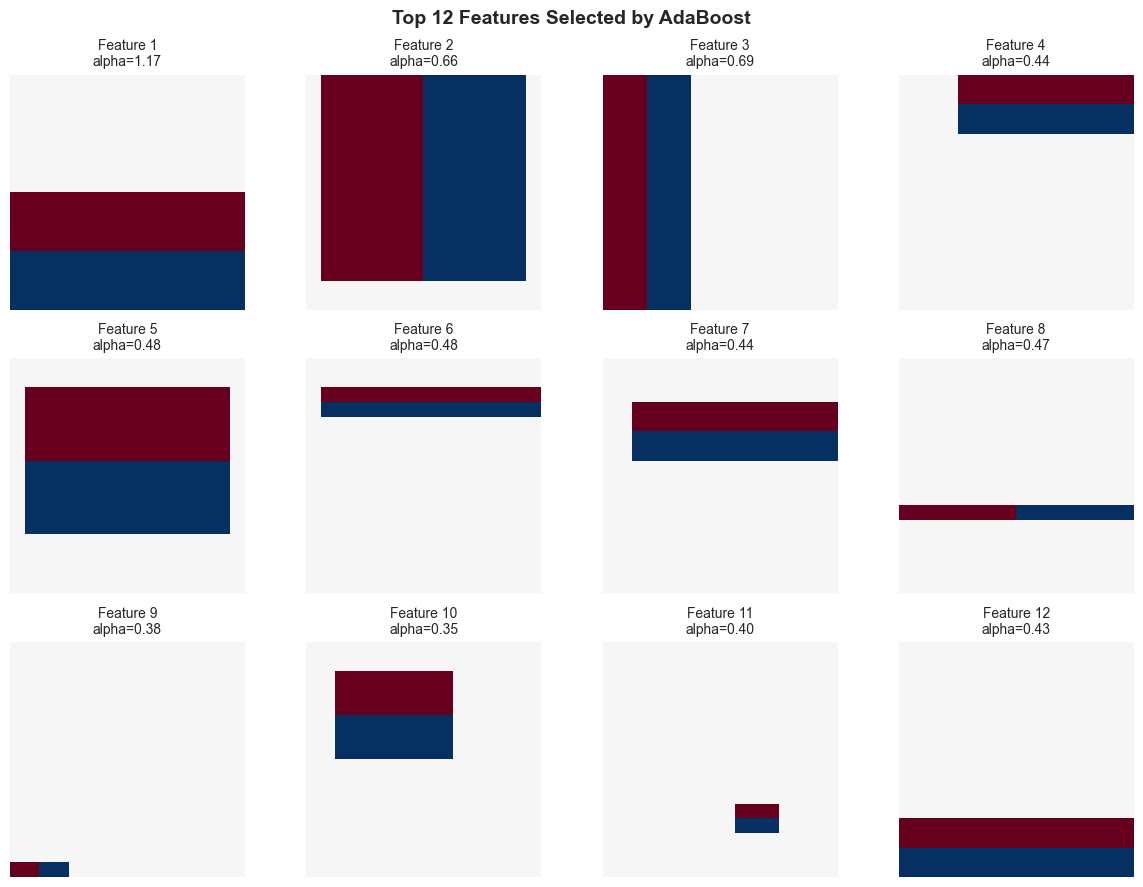

In [11]:
from features.haar_features import visualize_feature

# Show first 12 selected features
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Top 12 Features Selected by AdaBoost', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i >= len(classifier.weak_classifiers):
        break
    
    weak_clf = classifier.weak_classifiers[i]
    feature = features[weak_clf.feature_idx]
    alpha = classifier.alphas[i]
    
    # Visualize feature
    feat_img = visualize_feature(feature, window_size=16)
    ax.imshow(feat_img, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'Feature {i+1}\nalpha={alpha:.2f}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/figures/selected_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Results Summary

In [12]:
print("=" * 60)
print("ADABOOST V1 RESULTS SUMMARY")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Haar features: {len(features):,}")
print(f"  AdaBoost rounds (T): {T}")
print(f"  Weak classifiers selected: {len(classifier.weak_classifiers)}")

print(f"\nTraining Performance:")
print(f"  Accuracy:  {train_metrics['accuracy']:.2%}")
print(f"  Precision: {train_metrics['precision']:.2%}")
print(f"  Recall:    {train_metrics['recall']:.2%}")
print(f"  F1 Score:  {train_metrics['f1']:.2%}")

print(f"\nTest Performance:")
print(f"  Accuracy:  {test_metrics['accuracy']:.2%}")
print(f"  Precision: {test_metrics['precision']:.2%}")
print(f"  Recall:    {test_metrics['recall']:.2%}")
print(f"  F1 Score:  {test_metrics['f1']:.2%}")

print("\n" + "=" * 60)
if test_metrics['accuracy'] >= 0.70:
    print("[OK] V1 Milestone achieved! (>70% accuracy)")
else:
    print("Note: May need more features or rounds for better performance")
print("=" * 60)

ADABOOST V1 RESULTS SUMMARY

Configuration:
  Haar features: 10,000
  AdaBoost rounds (T): 50
  Weak classifiers selected: 50

Training Performance:
  Accuracy:  89.38%
  Precision: 62.59%
  Recall:    90.24%
  F1 Score:  73.91%

Test Performance:
  Accuracy:  84.97%
  Precision: 53.34%
  Recall:    78.45%
  F1 Score:  63.50%

[OK] V1 Milestone achieved! (>70% accuracy)


## Next Steps

1. **V1 Complete**: If accuracy >70%, V1 simplified version is working!
2. **Cascade**: Implement 2-stage cascade for improved false positive reduction
3. **V2 Scale-up**: Increase to 50k features and T=200 for better performance
4. **Detection**: Test on actual images with sliding windows